# Data sources, capture and simple visualization

## Data sources


The Singapore Land Transport Authority (LTA) provides an open API which can be used to fetch the taxi availability at any point of time. The data is from their data mall, updated every 30 seconds, and they recommend we strike the service every minute.

The data consists of the latitude and longitude of every taxi that is currently available i.e, not hired or busy. It doesnt provide any identifiable information about each taxi.

We can use this snapshot data and record it over a period of time to build a history of how the availability changed. The best visualization of this is to transform the co-ordinates into a grid and show aggregated count per grid cell.

A very good example of this can be found at - https://github.com/lihaoyi/opendata

This code formed the basis of the data gathering done for this talk.

## Capturing sufficient data

For the purpose of this talk a small script was run, every 5 minutes, to get the data snapshot and save it into a json file. This was done for a period from Saturday to the next Sunday.

The data in the json files was then transformed into a grid of height 20 and a width derived based on the lat lon box determined for Singapore. The transformed grid was saved to SQLite with each row containing the date,the grid cell coordinates, the hour and minute and the taxi count.This schema allows to get the taxi counts for a location for an entire day, or for a gievn location and time for the entire data collection period and similar data for all of Singapore

The raw latitude and longitude of the taxis is also stored - this is not really used for any analysis, but comes in handy if you want to plot and visualize the taxi locations.



## Lets setup some code and see some data

In [9]:
from sgtaxidata import *
import matplotlib.pyplot as plt

DBNAME="../taxis.db"
DBNAME_LG="../taxis_large.db"
DATE="20170626"
lat,lon=utils.get_lat_long("Sengkang")

## Data for a location and date

As you can see above we have a utility function to get the lat and lon for a given location. Using this lets try to see the data for Sengkang on a given date.

You will see that we store the time, the translated grid cell for that lat lon and the count of taxis at that point of time. The Point column acts as a proxy for the time as a number of steps, 5 mins each, from midnight

In [10]:
df=taxis.getdf_loc_date(DBNAME,DATE,lat,lon)
df.head()

,Point,Time,X,Y,TaxiCount
0,0,0000,24,12,48
1,1,0005,24,12,36
2,2,0010,24,12,50
3,3,0015,24,12,55
4,4,0020,24,12,48


You can also get the data for the entire city, or for a given location at a given time on a date or just all the data in the database for all dates. The last one you can even get with the lat and lon details instead of the translated grid cells.

That is a huge amount of data, and you can pick and choose the means of query based on what you want to do with the data. For the purposes of the machine learning we will do, we will always get the data per location per date and then fit the models accordingly.

We might filter based on the hours like morning rush hour etc, but that will be minimal.

## Some interesting plots with the raw data

Since we have all the lat and lon details in the raw data, lets see two quick examples of how we can plot this information. This looks cool and might come in handy later when you try your own analysis.

In [11]:
df_raw=taxis.get_df_all_taxi_data_raw_date(DBNAME,DATE)
df_s=taxis.get_df_all_taxi_data(DBNAME_LG)
df_s=df_s[df_s['Date']=='20170627']

In [12]:
from ipywidgets import interact

times=['0800','0805','0810','0815','0820','0825','0830','0835','0840','0845',\
       '0850','0855','0900','0905','0910','0915','0920','0925','0930','0935','0940','0945',\
       '0950','0955','1000','1005','1010','1015','1020','1025','1030','1035','1040','1045','1050','1055']

@interact(time=sorted(set(times)))
def data_at_time(time):
    df_s1=df_s[df_s['Time']==time]
    x=df_s1['X'].tolist()
    y=df_s1['Y'].tolist()
    sizes=[h*20 for h in df_s1['TaxiCount'].tolist()]
    visualize.plot_bubbles(x,y,sizes)

In [13]:
@interact(time=sorted(set(times)))
def data_at_time(time):
    df_raw_date_time=df_raw[df_raw['Time']==time]
    visualize.plot_map(df_raw_date_time,save=True)
    visualize.plot_map(df_raw_date_time)

In [14]:
for i,t in enumerate(times):
    df1=df_raw[df_raw['Time']==t]
    visualize.plot_map(df1,save=True,filename="picture"+str(i))
    
import subprocess
subprocess.call(["rm","out.avi"])
subprocess.call(["rm","out.gif"])
subprocess.call(["rm","picture*.avi"])
subprocess.call(["ffmpeg", "-f", "image2", "-i", "picture%*.png", "out.avi"])
subprocess.call(["ffmpeg","-i","out.avi","-t","5","out.gif"])

0

In [15]:
from IPython.display import HTML
HTML('<img src="out.gif">')

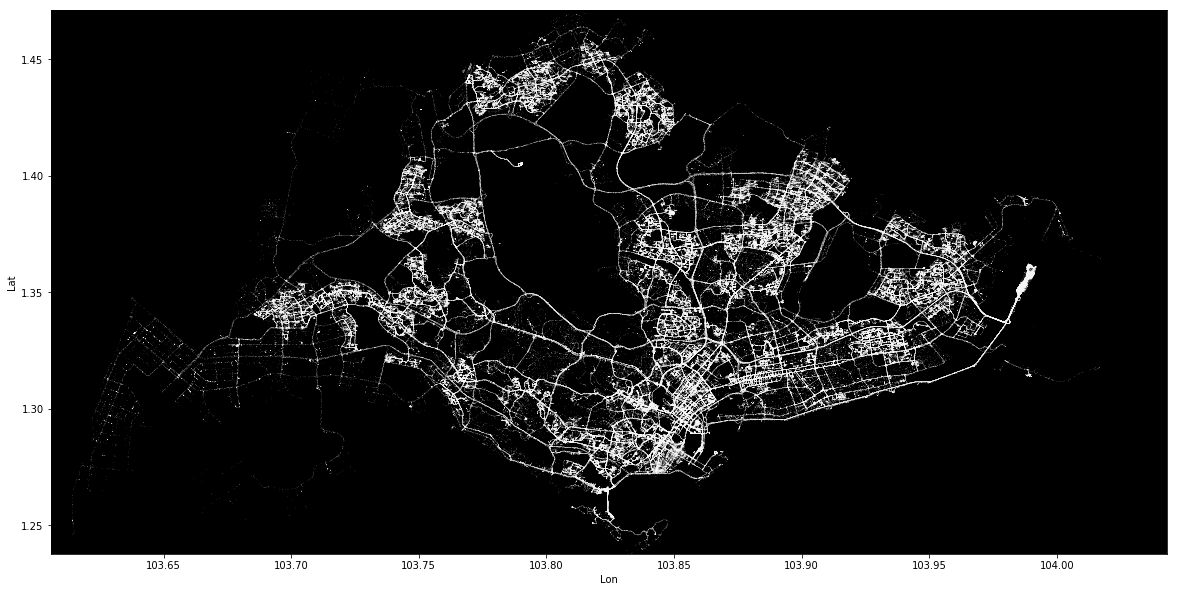

In [16]:
visualize.plot_map(df_raw,.001)